In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import numpy as np
#import copy

In [2]:
data_iris = load_iris()
X = data_iris['data']
y = data_iris['target']
X = (X - X.mean(axis=0))/X.std(axis=0)
X_train,X_test,y_train,y_test = train_test_split(X,y)

print(y_train.shape)

(112,)


In [3]:
X_train = np.append(X_train,X_train).reshape(-1,4)
y_train = np.append(y_train,y_train)

In [4]:
#num_classes=len(data_iris["target_names"])
num_classes = len(np.unique(y))
y_train.shape

(224,)

In [5]:
def batch_generator(X,y, batch_size):
        
    num_samples = X.shape[0]
    
    order = np.random.permutation(num_samples)
    num_batches = int(num_samples/batch_size)
    
    for i in range(num_batches):
        batch_indexes = order[i * batch_size:(i+1) * batch_size]
        
        X_ = X[batch_indexes]
        y_ = y[batch_indexes]
        
        yield X_,y_
        

In [6]:
def softmax(output_y):
    exp_output = np.exp(output_y)
    return exp_output/np.sum(exp_output, axis=1, keepdims=True)

def ReLU(output_):
    return np.maximum(0,output_)
    
class Dense_NN:
    def __init__(self):
        
        self.lr = None
        self.reg = None
        
        #weights
        self.W_ih = None
        self.W_ho = None
        
        self.b_ih = None
        self.b_ho = None
        
        self.f_output_ih = None #RElU
        #self.f_output_ho = None #Softmax
        
        self.train_losses = []
        self.test_losses = []
        
        self.train_acc = []
        self.test_acc = []
        
    def set_weights(self, input_size, size_hdn_layer, output_size):
        
        np.random.seed(30)
        
        self.W_ih = np.random.normal(0,0.01,(input_size, size_hdn_layer))
        self.W_ho = np.random.normal(0,0.01,(size_hdn_layer, output_size))
        
        self.b_ih = np.random.normal(0,0.01,(1,size_hdn_layer))
        self.b_ho = np.random.normal(0,0.01,(1,output_size))
        
    def correct_logprobs(self,y_true,y_pred):
        correct_logprob = -np.log(y_pred[range(len(y_true)),y_true])
        data_loss = np.sum(correct_logprob)/len(y_true)
                
        reg_loss = 0.5 * self.reg * np.sum(self.W_ih * self.W_ih) + \
                   0.5 * self.reg * np.sum(self.W_ho * self.W_ho)
        
        return data_loss + reg_loss
    
    def train(self, model,
              X_train, y_train, X_test, y_test, 
              output_size, h_layer_size =30,
              lr = 1e-3, reg =0.001,epochs=12000, delay_stopping=1000):
        
        batch_size = 25
        
        #set hyperparameters
        self.lr = lr
        self.reg = reg
        
        num_samples = X_train.shape[0]
        num_inputs = X_train.shape[1]
        
        self.set_weights(num_inputs, h_layer_size, output_size)
        
        best_loss_test = float('inf')
        #best_model = None
                
        for epoch in range(epochs):
            #clean metrics variables
            epoch_train_losses = []
            epoch_train_acc = []
                        
            for X_batch,y_batch in batch_generator(X_train, y_train, batch_size):
                
                y_pred_train = self.predict(X_batch)
                
                #loss function
                loss_train = self.correct_logprobs(y_batch, y_pred_train)
                epoch_train_losses.append(loss_train)
                
                #accuracy on train
                acc_train = np.sum((np.argmax(y_pred_train, axis=1) == y_batch))/len(y_batch) 
                            
                #append accuracy value for every bacth gradient
                epoch_train_acc.append(acc_train)
                
                #backpropagation
                self.backward(X_batch, y_batch, y_pred_train)
            
            #test predictions
            self.train_losses.append(np.mean(epoch_train_losses))
            self.train_acc.append(np.mean(epoch_train_acc))
            
            #test predicitons
            y_pred_test = self.predict(X_test)
            
            #calculating loss function and saving it
            loss_test = self.correct_logprobs(y_test, y_pred_test)
            self.test_losses.append(loss_test)
        
            #calculating accuracy value and saving it            
            
            acc_test = np.sum(np.argmax(y_pred_test, axis=1) == y_test)/len(y_test)
            self.test_acc.append(acc_test)
           
            if epoch % 100 == 0:
                print("Epoch {}. train_loss: {:.4f} - test_loss {:.4f} ".
                      format(epoch, np.mean(epoch_train_losses),loss_test))

            if loss_test < best_loss_test:
                best_loss_test = loss_test
                #best_model = copy.deepcopy(model)
                best_epoch = epoch
            elif (epoch - best_epoch) == delay_stopping:
                print("Stopped on epoch {}. Best loss value: {:.4f} on epoch {}".
                     format(epoch,best_loss_test,best_epoch))     
                break
                
        return self.train_losses, self.test_losses
    
    def predict(self, X_):
        output_ih = np.dot(X_, self.W_ih) + self.b_ih
        self.f_output_ih = ReLU(output_ih)
        
        output_ho = np.dot(self.f_output_ih, self.W_ho) + self.b_ho
        #self.f_output_ho = softmax(output_ho) 
        
        #return predicted classes by its probability
        return softmax(output_ho) 
    

    def backward(self, X_batch, y_batch, y_pred):
        
        dscores = y_pred
        dscores[range(X_batch.shape[0]),y_batch] -= 1
        dscores /= X_batch.shape[0]
        
        dW2 = np.dot(self.f_output_ih.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        
        dhidden = np.dot(dscores, self.W_ho.T)
        dhidden[self.f_output_ih <= 0] = 0
        
        dW1 = np.dot(X_batch.T, dhidden)
        db1 = np.sum(dhidden, axis=0, keepdims=True)
        
        dW2 += self.reg * self.W_ho
        dW1 += self.reg * self.W_ih
        
        #parameters update
        self.W_ho += -self.lr * dW2
        self.b_ho += -self.lr * db2
        
        self.W_ih += -self.lr * dW1
        self.b_ih += -self.lr * db1


In [7]:
model = Dense_NN()

train_losses, test_losses = model.train(model, X_train, y_train, X_test, y_test,num_classes)

Epoch 0. train_loss: 1.0982 - test_loss 1.0998 
Epoch 100. train_loss: 1.0968 - test_loss 1.1003 
Epoch 200. train_loss: 1.0941 - test_loss 1.0986 
Epoch 300. train_loss: 1.0846 - test_loss 1.0922 
Epoch 400. train_loss: 1.0561 - test_loss 1.0732 
Epoch 500. train_loss: 0.9975 - test_loss 1.0259 
Epoch 600. train_loss: 0.8843 - test_loss 0.9387 
Epoch 700. train_loss: 0.7660 - test_loss 0.8350 
Epoch 800. train_loss: 0.6555 - test_loss 0.7443 
Epoch 900. train_loss: 0.5999 - test_loss 0.6708 
Epoch 1000. train_loss: 0.5432 - test_loss 0.6128 
Epoch 1100. train_loss: 0.4929 - test_loss 0.5673 
Epoch 1200. train_loss: 0.4656 - test_loss 0.5305 
Epoch 1300. train_loss: 0.4253 - test_loss 0.4994 
Epoch 1400. train_loss: 0.4146 - test_loss 0.4718 
Epoch 1500. train_loss: 0.3760 - test_loss 0.4470 
Epoch 1600. train_loss: 0.3639 - test_loss 0.4246 
Epoch 1700. train_loss: 0.3635 - test_loss 0.4039 
Epoch 1800. train_loss: 0.3428 - test_loss 0.3851 
Epoch 1900. train_loss: 0.3128 - test_loss 

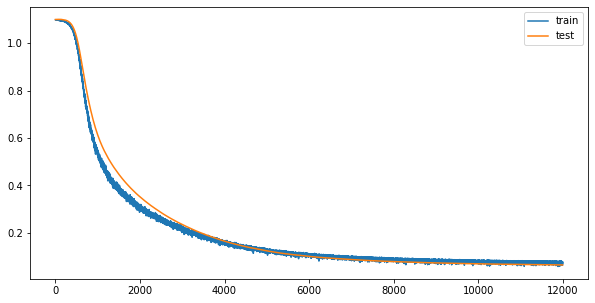

In [9]:
plt.plot(range(len(train_losses)),train_losses, label='train')
plt.plot(range(len(test_losses)),test_losses, label='test')
plt.legend()
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

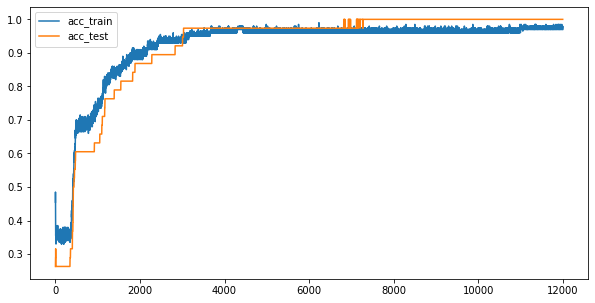

In [10]:
accuracy_train = model.train_acc
accuracy_test = model.test_acc

plt.plot(range(len(accuracy_train)), accuracy_train, label='acc_train')
plt.plot(range(len(accuracy_test)), accuracy_test, label='acc_test')
plt.legend()
plt.rcParams["figure.figsize"] = (10,5)
plt.show()

In [11]:
from sklearn.metrics import accuracy_score

_train_pred = model.predict(X_train)
_test_pred = model.predict(X_test)

accuracy_train = accuracy_score(y_train,np.argmax(_train_pred,axis=1))
accuracy_test = accuracy_score(y_test,np.argmax(_test_pred, axis=1))

In [12]:
print(accuracy_train)
print(accuracy_test)

0.9732142857142857
1.0
